# 연습문제 3

## #01. 공통

### 패키지

In [11]:
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import DataFrame, read_excel, read_csv

# 분류 알고리즘 패키지
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score #분류

# 군집을 위한 패키지
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler #군집

# 평가함수
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score

### 데이터 준비

In [12]:
origin = read_csv("data/03-citrus.csv")
origin.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [13]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [14]:
origin.isna().sum()

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

### 전처리

#### 라벨링을 위해 종속변수 종류 확인

In [15]:
labels  = list(origin['name'].unique())
labels

['orange', 'grapefruit']

#### 라벨링 적용

In [21]:
df = origin.copy()
df['name'] = df['name'].map({'orange':0, 'grapefruit':1})
df.head()

,name,diameter,weight,red,green,blue
0,0,2.96,86.76,172,85,2
1,0,3.91,88.05,166,78,3
2,0,4.42,95.17,156,81,2
3,0,4.47,95.60,163,81,4
4,0,4.48,95.76,161,72,9


#### 독립변수(feature), 종속변수(label) 분리

군집은 종속변수 없음

분류는 종속변수 있음

In [22]:
x = df.drop('name', axis=1) #DF 객체
y = df['name']  #Series 객체
x.shape, y.shape

((10000, 5), (10000,))

In [23]:
y.isna().sum()

0

## #02. KNN 분류

### 1. 분류기 생성

>최적의 `k`값 생성을 위해 k가 1부터 데이터 수(여기서는 10000)건까지 반복하면서 최적의 k값을 탐색.
여기서는 실행 속도, 시간 등을 고려해 k의 최대값을 10으로 제한

#### 분류 모델 구성(k-fold)

In [24]:
k_range = range(1,11)
k_score = []

for k in k_range:   #10회 반복
    # 모델 정의(사용하려는 알고리즘 선택)
    knn = KNeighborsClassifier(n_neighbors=k)
    # 교차검증
    scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')  #knn 10번 수행
    k_score.append(scores.mean())

# k_scores

#### 가장 큰 정확도와 그에 대한 k 값

In [25]:
max_acc = max(k_score)
max_index = k_score.index(max_acc)
print("최대 정확도 : {0}, 최대 정확도를 갖는 k : {1}".format(max_acc, max_index+1))

최대 정확도 : 0.8426, 최대 정확도를 갖는 k : 10


#### 최적의 k값을 적용한 KNN 분류기

In [26]:
knn = KNeighborsClassifier(n_neighbors=max_index+1)
knn.fit(x,y)    #학습
y_pred = knn.predict(x) #예측값
y_pred_df = DataFrame({"y":y.values, "y_pred":y_pred})  
y_pred_df

,y,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
9995,1,1
9996,1,1
9997,1,1
9998,1,1


### 2. 결과 평가

#### 혼동행렬

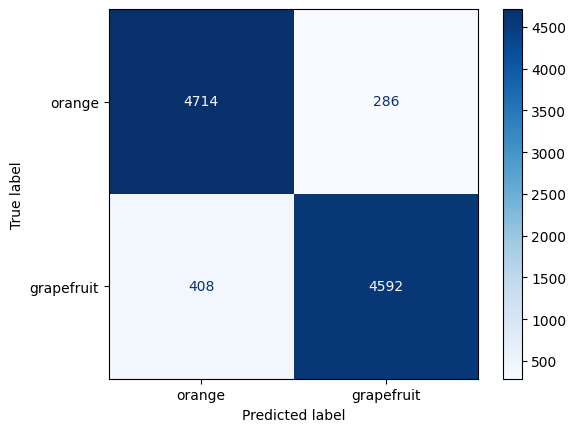

In [27]:
plot = ConfusionMatrixDisplay.from_predictions(
    y_pred_df['y'], y_pred_df['y_pred'],
    display_labels=labels,
    cmap=plt.cm.Blues
)
plt.show()
plt.close()

#### 정확도, 정밀도, 재현율, f 값

아래는 2진분류가 아니라도 범용적으로 사용이 가능
- 오차행렬(혼동행렬) : 'confusion_matrix(관측치, 예측치)'
- 정확도 : 'accuracy_score(관측치, 예측치)'

아래는 왠만해서는 binary 형태로 사용
- 정밀도 : 'precision_score(관측치, 예측치)'
- 재현율 : 'recall_score(관측치, 예측치)'
- F1 스코어 : 'f1_score(관측치, 예측치)'
- ROC 곡선 : 'roc_curve(관측치, 예측치)'
- 분류 리포트 : 'classification_report(관측치, 예측치)'
- AUC : 'roc_auc_score(관측치, 예측치)'

불균형한 레이블 클래스를 가지는 이진 분류 모델에서 정확도만 가지고 판단할 경우 신뢰도가 떨어질 수 있다. 이럴 경우 **정밀도 혹은 재현율**을 사용하는 것이 더욱 바람직.

- 정밀도 : 실제 음성인 데이터를 양성으로 판단하는 것이 더 큰 문제인 경우 사용.(ex: 스팸 메일 분류 모델)
- 재현율 : 실제 양성인 데이터를 음성으로 판단하는 것이 더 큰 문제인 경우 사용.(ex: 암 판단 모델)

In [28]:
score = accuracy_score(y.values, y_pred)
print("정확도 : %.2f%%"%(score*100))
# print("n_naighbors: {0}, 정확도: {1}".format(k, scores))

scores = precision_score(y_pred_df['y'], y_pred_df['y_pred'], average='macro')
print("n_neighbors : {0}, 정밀도 : {1:.2f}".format(k,scores))

scores = recall_score(y_pred_df['y'], y_pred_df['y_pred'], average='macro')
print("n_neighbors : {0}, 재현율 : {1:.2f}".format(k,scores))

scores = f1_score(y_pred_df['y'], y_pred_df['y_pred'], average='macro')
print("n_neighbors : {0}, f값 : {1:.2f}".format(k,scores))

정확도 : 93.06%
n_neighbors : 10, 정밀도 : 0.93
n_neighbors : 10, 재현율 : 0.93
n_neighbors : 10, f값 : 0.93


## #03.KMeans 군집

### 1. 데이터 표준화

In [37]:
scaler = MinMaxScaler()
scaler.fit(x)
n_data = scaler.transform(x)

print("각 열의 평균값 :", n_data[:,0].mean().round(3), n_data[:,1].mean().round(3), n_data[:,2].mean().round(3), n_data[:,3].mean().round(3), n_data[:,4].mean().round(3))    #0~4번째 열 평균
print("각 열의 최소 :", n_data[:,0].min().round(3), n_data[:,1].min().round(3), n_data[:,2].min().round(3), n_data[:,3].min().round(3), n_data[:,4].min().round(3))    #0~4번째 열 최소
print("각 열의 최대값 :", n_data[:,0].max().round(3), n_data[:,1].max().round(3), n_data[:,2].max().round(3), n_data[:,3].max().round(3), n_data[:,4].max().round(3))    #0~4번째 열 최대

각 열의 평균값 : 0.52 0.505 0.505 0.53 0.173
각 열의 최소 : 0.0 0.0 0.0 0.0 0.0
각 열의 최대값 : 1.0 1.0 1.0 1.0 1.0


### 2. 군집 모델 생성

#### #Inertia에 의한 최적의 군집 수 탐색

>Inertia

KMeans 클러스터링의 성능 지표

각 샘플과 중점이 이동하는 자취 사이의 평균 제곱거리 측정 값

Inertia 값은 클러스터 수와 반비례 관계

클러스터 수를 늘려가면서 반복적으로 실행하면 값이 점점 작아진다

클러스터 수가 늘어감에 Inertia가 급격히 감소하고 어느 지점부터는 완만하게 감소하는 지점이 생기는데 이 지점이 최적 클러스터 수를 의미(=엘보우(Elbow))

In [38]:
iner = []

for k in range(2,11):   
    kmeans = KMeans(n_clusters=k, random_state=777)
    # 학습
    kmeans.fit(n_data)
    kmeans.inertia_
    iner.append(kmeans.inertia_)
iner

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

[691.7541442472321,
 588.3928583210006,
 529.8936507734145,
 486.06569083410847,
 450.25653897931545,
 420.94133514430644,
 396.17367403420315,
 376.13357088591897,
 357.1354247483785]

#### Inertia 결과 시각화

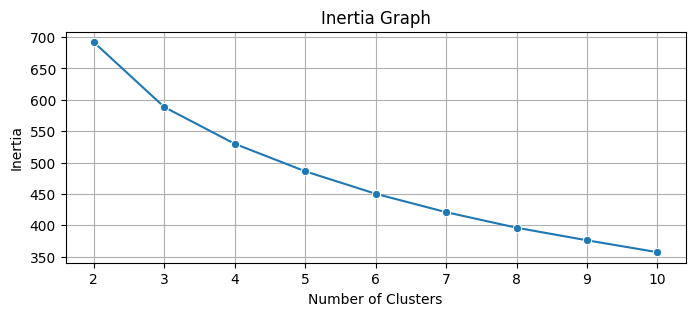

In [41]:
plt.figure(figsize=(8,3))
sb.lineplot(x=range(2,11), y=iner, marker='o')
plt.title("Inertia Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.grid()
plt.show()
plt.close()

> 경사도가 완만해지기 시작하는 부분을 도출(분석가 주관이 개입)

4 아니면 5로 판단

#### #실루엣 점수에 의한 판단

>실루엣 점수(계수)

각 군집간의 거리가 얼마나 효율적으로 분리됐는지를 나타내는 지표

효율적 분리 : 어떤 한 점이 다른 군집과는 멀리 떨어져 있고, 동일 군집끼리는 서로 가깝게 잘 뭉쳐있음을 의미

개별 데이터가 같은 군집과는 얼마나 가깝고, 다른 군집의 데이터와는 얼마나 멀리 분리되어 있는가를 나타내는 값

sklearn은 전체 실루엣 점수의 평균값을 반환하는 `silhouette_score()` 함수를 제공

리턴값은 `-1~1`의 범위를 가지며 1에 가까울 수록 좋은 군집으로 판단

`0`인 경우는 클러스터가 겹치는 것을 의미

음수값은 일반적으로 샘플이 잘못된 클러스터에 할당되었음을 의미

> 실루엣 방법은 점수가 나오는 만큼 비교적 더 정확함

>클러스터 수가 2개 이상일 때 비로소 의미를 가지며, 최소한 두 개의 클러스터가 필요

In [42]:
# kmeans = KMeans(n_clusters=4, random_state=777)
# # 학습
# kmeans.fit(n_data)
# # 예측
# y_pred = kmeans.predict(n_data)

# score = silhouette_score(n_data, y_pred)
# print("실루엣 점수 : {0:.3f}".format(score))

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 점수 : 0.189


In [43]:
sil = []
# 
'''
range가 2부터 시작하는 이유
실우엣 점수는 클러스터 수가 2개 이상일 때 
의미를 가지므로 최소한 두 개의 클러스터가 필요'''
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=777)
    # 학습
    kmeans.fit(n_data)
    # 예측
    y_pred = kmeans.predict(n_data)
    # 결과 값
    score = silhouette_score(n_data, y_pred)
    sil.append(score)

sil

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

[0.3398591427944969,
 0.2666267799759814,
 0.18874217108498184,
 0.18951319806151276,
 0.18543429065453665,
 0.18057879120206322,
 0.18029658797498216,
 0.1762543694949217,
 0.17844116110688227]

#### 실루엣 결과 시각화

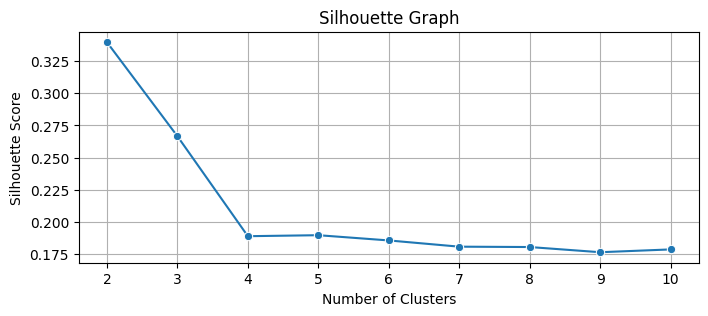

In [45]:
plt.figure(figsize=(8,3))
sb.lineplot(x=range(2,11), y=sil, marker='o')
plt.title("Silhouette Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.grid()
plt.show()
plt.close()

#### 군집수를 `2`로 설정해 모델 구현 및 시각화

In [48]:
df.columns

Index(['name', 'diameter', 'weight', 'red', 'green', 'blue', 'y_pred_kmeans'], dtype='object')

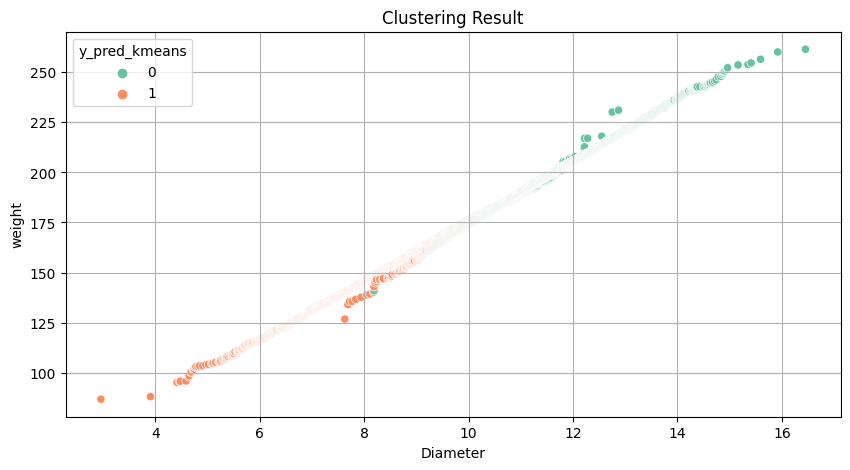

In [50]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=777)
# 학습
kmeans.fit(n_data)
# 예측
y_pred = kmeans.predict(n_data)

y_pred_df['y_pred_kmeans'] = y_pred
# y_pred_df
df['y_pred_kmeans'] = y_pred
df

plt.figure(figsize=(10,5))
sb.scatterplot(data=df, x='diameter', y='weight', hue='y_pred_kmeans', palette='Set2')
plt.title("Clustering Result")
plt.xlabel("Diameter")
plt.ylabel("weight")
plt.grid()
plt.show()
plt.close()

In [52]:
df

,name,diameter,weight,red,green,blue,y_pred_kmeans
0,0,2.96,86.76,172,85,2,1
1,0,3.91,88.05,166,78,3,1
2,0,4.42,95.17,156,81,2,1
3,0,4.47,95.60,163,81,4,1
4,0,4.48,95.76,161,72,9,1
...,...,...,...,...,...,...,...
9995,1,15.35,253.89,149,77,20,0
9996,1,15.41,254.67,148,68,7,0
9997,1,15.59,256.50,168,82,20,0
9998,1,15.92,260.14,142,72,11,0


In [51]:
y_pred_df['y_pred_kmeans'] = y_pred
y_pred_df

,y,y_pred,y_pred_kmeans
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
9995,1,1,0
9996,1,1,0
9997,1,1,0
9998,1,1,0


In [53]:
df['y_pred_knn'] = y_pred_df['y_pred_kmeans']
df

,name,diameter,weight,red,green,blue,y_pred_kmeans,y_pred_knn
0,0,2.96,86.76,172,85,2,1,1
1,0,3.91,88.05,166,78,3,1,1
2,0,4.42,95.17,156,81,2,1,1
3,0,4.47,95.60,163,81,4,1,1
4,0,4.48,95.76,161,72,9,1,1
...,...,...,...,...,...,...,...,...
9995,1,15.35,253.89,149,77,20,0,0
9996,1,15.41,254.67,148,68,7,0,0
9997,1,15.59,256.50,168,82,20,0,0
9998,1,15.92,260.14,142,72,11,0,0


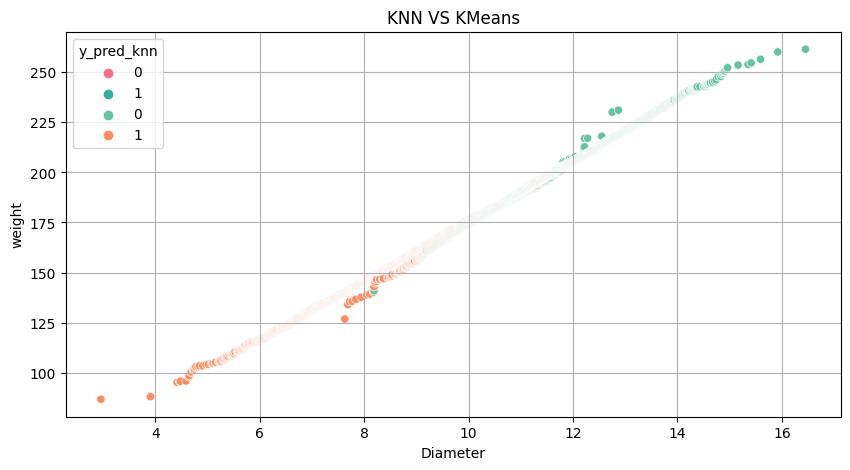

In [68]:
plt.figure(figsize=(10,5))
sb.scatterplot(data=df, x='diameter', y='weight', hue='y_pred_kmeans', palette='husl')
sb.scatterplot(data=df, x='diameter', y='weight', hue='y_pred_knn', palette='Set2')


plt.title("KNN VS KMeans")
plt.xlabel("Diameter")
plt.ylabel("weight")
plt.grid()
plt.show()
plt.close()

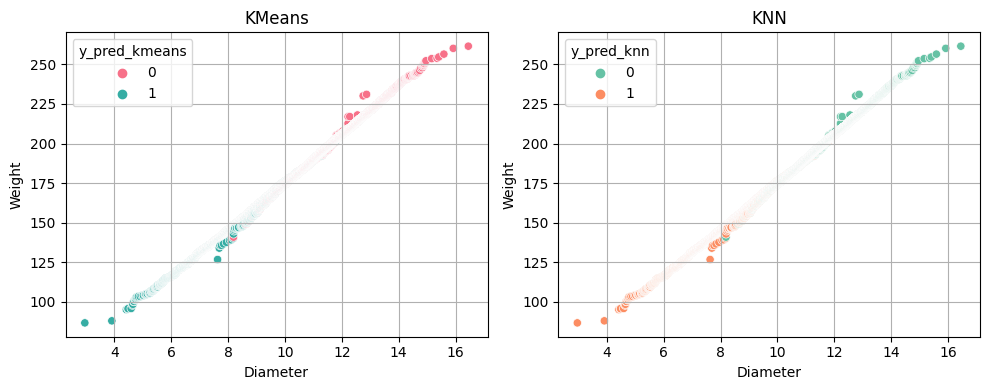

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# KMeans
sb.scatterplot(data=df, x='diameter', y='weight', hue='y_pred_kmeans', palette='husl', ax=ax1)
ax1.set_title("KMeans")
ax1.set_xlabel("Diameter")
ax1.set_ylabel("Weight")
ax1.grid()

# KNN
sb.scatterplot(data=df, x='diameter', y='weight', hue='y_pred_knn', palette='Set2', ax=ax2)
ax2.set_title("KNN")
ax2.set_xlabel("Diameter")
ax2.set_ylabel("Weight")
ax2.grid()

plt.tight_layout()
plt.show()
plt.close()